In [ ]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Reading and Plotting Shapefiles
When we plot state borders, coastlines, rivers, etc. on a map, we are plotting data that is stored in a shapefile. A shapefile can contain any combination of the following geometry: Point, MultiPoint, Line, MultiLine, Polygon, and MultiPolygon. These geo-referenced data objects are widely used in GIS applications. A common source of shapefiles come from the decenial census and are commonly referred to as Tiger Files. Increasingly there are other data being distributed in this same format including projects from the National Weather Service.

Natural Earth Webiste: https://www.naturalearthdata.com

NWS Shapefiles Data: https://www.weather.gov/gis/NWS_Shapefile

Census Data: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In this notebook we'll demonstrate how to:
* Download shapefiles from Natural Earth Data (since you cannot load them remotely)
* Investigate the GeoDataFrame, its similarities and differences to a Pandas DataFrame
* Plot Point, Line, and Polygon data
* Clip our Shapfile data based on a Polygon of our own creation
* Read a remote shapefile and plot some Polygons

## Download the road data

Let's go to the Natural Earth Data website and find a file to download. Data are located under the "Download" tab and there is different data available in the three scales of 1:10 million, 1:50 million, and 1:100 million. Let's take a look at the data available for the scale of 1:10 million.

Let's find roads under the Cultural grouping of files...

https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

## Reading Shapefiles

There is a nice package called GeoPandas, which can allow us to easily read in, work with, and manipulate our shapefile data. What lies at the heart of these shapefiles are tabular data (hence why using a Pandas base is logical) and the addition to a traditional Pandas DataFrame are one or more columns that contain the geometry (Point, Line, Polygon) of our data.

GeoPandas Documentation: https://geopandas.org/docs/user_guide.html

These geometries are Shapely base objects, which are Python implementations of PostGIS patial extension for the PostgreSQL RDBMS. Essentially what this means is that this is the Pythonic way of reading and maniuplating the same objects that are used in all common GIS platforms. To read more about Shapely and how we can work with these Point, Line, and Polygon objects, visit the Shapely documentation at: https://shapely.readthedocs.io/en/stable/manual.html#geometric-objects

But for now, let's read in our data that we downloaded using GeoPandas `read_file()` method.

```python
gdf = gpd.read_file(<filename>)
```

Since we have downloaded the file from within our notebook, that will have placed the file in the working directory that the notebook resides in, so we'll just have to provide the name of the file.

There is a lot of data contained within this file. Let's first see what types of roads that we have within the GeoDataFrame.

We also have data from many different continents.

Let's subset our data for just Interstate in USA.

## Plotting Shapefile

Let's work to plot the North American Major Highways. To do this we'll need the `.add_geometries()` method, which comes with our projected axes.

The key to adding geometries is that you are looking to feed in the column of data that contains the geometry you wish to plot, whether a Point, a Line, or a Polygon.

```python
ax.add_geometries(<geometry column>, crs, **kwargs)
```

In [ ]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=ccrs.LambertConformal(central_longitude=-88.75))

ax.set_extent([-89, -86, 39, 43], ccrs.PlateCarree())

ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))

ax.add_geometries()

plt.show()

## Plotting Forecast Shapefiles
The NWS has a number of different shapefiles that contain forecasts or other elements. These files we can read in remotely from the website, which is nice, because these change with some forecast frequency.

https://www.cpc.ncep.noaa.gov/products/GIS/GIS_DATA/

From the CPC website, let's read in the 6-10 day forecast for the temperature. It will be best to use the "latest" link, so that whenever you pull this data, you'll always get the most recent forecast!

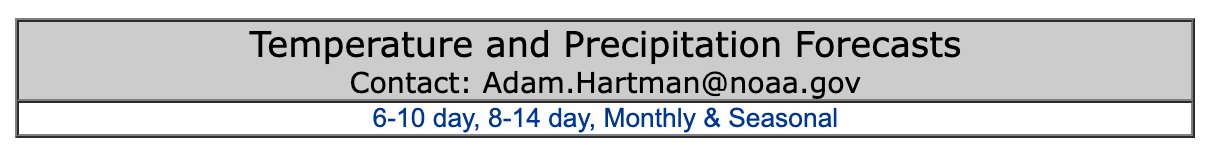

In [ ]:
outlook = 

Take a quick look at the data.

In [ ]:
outlook.plot()

This data contains forecasts for not only the CONUS, but Alaska and Hawaii as well. To simpify the plotting, I just want to plot the CONUS, so in order to subset our GeoDataFrame, we'll need to clip our data. To do this we'll need to set up a Polygon that is slightly bigger than the CONUS area. 

To set a Polygon, we'll use the Shapely Geometry object, Polygon, and set a series of five points where the first and the last point are the same, so define four line segments that will be connected and allow Python to determine what is within and what is outside of that particular Polygon for subsetting purposes.

Our five points:
* Lower Left Point: -130E, 20N
* Upper Left Point: -130E, 50N
* Upper Right Point: -60E, 50N
* Lower Right Point: -60E, 20N
* Original Point: -130E, 20N

Each point is entered as a tuple pair value within a simple list

```python
clip_polygon = Polygon([(-130, 20), (-130, 50), (-60, 50), (-60, 20), (-130, 20)])
```

Then we use the `.clip()` method available through our GeoDataFrame, feeding it the clip Polygon that we just defined.

```python
subset = gdf.clip(clip_polygon)
```

In [ ]:
# Create a custom polygon
US_clip_polygon = Polygon([(-130, 20), (-130, 50), (-60, 50), (-60, 20), (-130, 20)])

outlook = 

Now how do we go about plotting these forecasts?

Each discrete Polygon is on its own line, so we can plot one at a time and add some color based on the the probability. To do this we'll need to employ some looping and pulling colors from a colormap.

In [ ]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.LambertConformal())

ax.set_extent([-124, -65, 22, 50], ccrs.PlateCarree())

# Plot Above Average
    # First ID just the above normal forecast polygons
above = outlook[outlook.Cat == 'Above']
    # Grab a warm color colormap that we'll be able to pull colors from
    # later based on the probablility of the forecast
above_cmap = plt.cm.get_cmap('YlOrRd')
    # Now loop over all of the rows from the GeoDataFrame
    # Add the geometries as we go along, choosing the color from our
    # colormap based on the fraction probability
for _, poly in above.iterrows():
    ax.add_geometries([poly['geometry']], facecolor = above_cmap(poly['Prob']/100),
                      edgecolor='black', crs=ccrs.PlateCarree())
    # If the probability is a maximum value, find the centroid point and plot
    # ABOVE at that point.
    if poly.Prob == above.Prob.max():
        lon, lat = poly.geometry.centroid.coords[0]
        ax.text(lon, lat, 'Above', fontdict = {'fontsize': 16, 'fontweight':'bold'},
                ha='center', transform=ccrs.PlateCarree())

# Plot Below Average
    # First ID just the below normal forecast polygons

    # Grab a cold color colormap that we'll be able to pull colors from
    # later based on the probablility of the forecast

    # Now loop over all of the rows from the GeoDataFrame
    # Add the geometries as we go along, choosing the color from our
    # colormap based on the fraction probability

    # If the probability is a maximum value, find the centroid point and plot
    # BELOW at that point.


# Plot Near Normal
normal = outlook[outlook.Cat == 'Normal']
for _, poly in normal.iterrows():
    ax.add_geometries(poly.geometry, facecolor = 'lightgrey',
                      crs = ccrs.PlateCarree())
    # Here we plot just a representative point within the region of Normal values
    lon, lat = poly.geometry.representative_point().coords[0]
    ax.text(lon, lat, 'Near\nNormal', fontdict = {'fontsize': 16, 'fontweight':'bold'},
            ha='center', transform=ccrs.PlateCarree())

# Add state and coastline boundaries
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='grey')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey')

# Use the date/times from the file to set some appropriate titles
sdate = pd.to_datetime(outlook.Start_Date.values[0])
edate = pd.to_datetime(outlook.End_Date.values[0])
idate = pd.to_datetime(outlook.Fcst_Date.values[0])
ax.set_title(f'CPC 6-10 Day Temperature Outlook\nValid: {sdate:%d %B %Y} - {edate:%d %B %Y}', loc='left')
ax.set_title(f'\nIssued: {idate: %d %B %Y}', loc='right')

plt.show()